In [9]:
from collections import Counter
import nltk
import pandas as pd
#from emoticons import EmoticonDetector
import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim

# plotly configuration
plotly.offline.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [10]:
class Data_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["id","comment", "emotion", "date","url"])
            self.data = self.data[self.data["emotion"].isin(["positive", "negative"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "comment"],dtype={"id":"int64","text":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["comment"])
            not_null_id = 1 ^ pd.isnull(self.data["id"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

In [11]:
data = Data_Initialize()
data.initialize("data\\four-column500v1.4.csv")
data.processed_data.head(5)

,id,comment,emotion,date,url
0,0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,2,"brabi orange, pk l'connexion ,ma@ t7ebech temc...",negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,3,slm orange elyoum 3adet fourfi 900 ta3 7 jour ...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,4,N7eb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...


In [12]:
df = data.processed_data
neg = len(df[df["emotion"] == "negative"])
pos = len(df[df["emotion"] == "positive"])
#neu = len(df[df["emotion"] == "neutral"])
dist = [
    graph_objs.Bar(
        x=["negative","positive"],
        y=[neg, pos],
)]

In [19]:
class PostCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "comment"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return PostCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["comment"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "comment"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return PostCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return PostCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [20]:
class Data_Cleansing(Data_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [21]:
data = Data_Cleansing(data)
data.cleanup(PostCleanuper())
data.processed_data.head(5)

,id,comment,emotion,date,url
0,0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,2,brabi orange pk lconnexion ma tebech temchili ...,negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,3,slm orange elyoumadet fourfi ta jour tantli ma...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,4,Neb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...


In [22]:
class Data_TokenStem(Data_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["comment"] = list(map(lambda str: stemmer.stem(str.lower()), row["comment"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["comment"] = tokenizer(row["comment"])
            row["tokenized_text"] = [] + row["comment"]
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)

In [23]:
nltk.word_tokenize('في_بيتنا كل شي لما تحتاجه يضيع ...ادور على شاحن فجأة يختفي  ')

['في_بيتنا',
 'كل',
 'شي',
 'لما',
 'تحتاجه',
 'يضيع',
 '...',
 'ادور',
 'على',
 'شاحن',
 'فجأة',
 'يختفي']

In [24]:
data = Data_TokenStem(data)
data.tokenize()
data.stem()
data.processed_data.head(5)

,id,comment,emotion,date,url,tokenized_text
0,0,"[عسلامة, أورونج, رقدت, مخلي, ال, puce, متاعي, ...",negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...,"[عسلامة, أورونج, رقدت, مخلي, ال, puce, متاعي, ..."
1,1,"[اورونج, نحب, نقلكم, عيشكم, خاتر, انتوما, الوح...",negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...,"[اورونج, نحب, نقلكم, عيشكم, خاتر, انتوما, الوح..."
2,2,"[brabi, orang, pk, lconnexion, ma, tebech, tem...",negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...,"[brabi, orange, pk, lconnexion, ma, tebech, te..."
3,3,"[slm, orang, elyoumadet, fourfi, ta, jour, tan...",negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...,"[slm, orange, elyoumadet, fourfi, ta, jour, ta..."
4,4,"[neb, orang]",positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...,"[Neb, orange]"


In [25]:
##############"Building the wordlist

In [26]:
words = Counter()
for idx in data.processed_data.index:
    words.update(data.processed_data.loc[idx, "comment"])
words.most_common(5)

[('merci', 196), ('orang', 137), ('و', 72), ('في', 72), ('w', 63)]

In [27]:
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

[('merci', 196), ('orang', 137), ('و', 72), ('في', 72), ('w', 63)]

In [28]:
class Data_Wordlist(Data_TokenStem):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    whitelist = ["n't","not"]
    wordlist = []
        
    def build_wordlist(self, min_occurrences=3, max_occurences=500, stopwords=nltk.corpus.stopwords.words("english"),
                       whitelist=None):
        self.wordlist = []
        whitelist = self.whitelist if whitelist is None else whitelist
        import os
        if os.path.isfile("data\\wordlistv1.4.csv"):
            word_df = pd.read_csv("data\\wordlistv1.4.csv",encoding="latin-1")
            word_df = word_df[word_df["occurrences"] > min_occurrences]
            self.wordlist = list(word_df.loc[:, "word"])
            return

        words = Counter()
        for idx in self.processed_data.index:
            words.update(self.processed_data.loc[idx, "comment"])

        for idx, stop_word in enumerate(stopwords):
            if stop_word not in whitelist:
                del words[stop_word]

        word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                     "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                               columns=["word", "occurrences"])

        word_df.to_csv("data\\wordlistv1.4.csv", index_label="idx")
        self.wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]


In [29]:
data = Data_Wordlist(data)
data.build_wordlist()

In [30]:
words = pd.read_csv("data\\wordlistv1.4.csv", encoding="latin-1")
x_words = list(words.loc[0:5,"word"])
x_words.reverse()
y_occ = list(words.loc[0:5,"occurrences"])
y_occ.reverse()

dist = [
    graph_objs.Bar(
        x=y_occ,
        y=x_words,
        orientation="h"
)]
#plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Top words in built wordlist")})

In [31]:
#import codecs
#with codecs.open("data\\wordlistv1.4.csv", "r",encoding='utf-8', errors='ignore') as fdata:

In [32]:
#with open("data\\wordlist.csv", encoding="latin-1") as datafile:
#words = pd.read_csv("data\\wordlistv1.4.csv", encoding="latin-1")

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

<Container object of 6 artists>

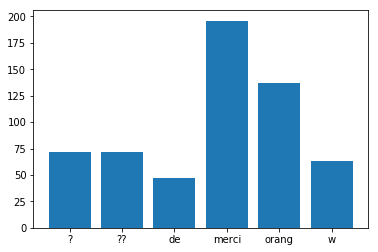

In [34]:
plt.bar(x_words,y_occ)

In [35]:
################Bag-of-words

In [36]:
class Data_BagOfWords(Data_Wordlist):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        self.wordlist = previous.wordlist
    
    def build_data_model(self):
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + list(
            map(lambda w: w + ">",self.wordlist))
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "emotion"]
                labels.append(current_label)
                current_row.append(current_label)

            # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "comment"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels

In [37]:
data = Data_BagOfWords(data)
bow, labels = data.build_data_model()
bow.head(5)

,label,merci>,orang>,و>,في>,w>,de>,le>,من>,dima>,...,bonu>,فلوس>,forfait>,lel>,يكون>,وكل>,oredoo>,ooredoo>,wala>,tunisi>
0,negative,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,negative,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,negative,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,negative,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,positive,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
grouped = bow.groupby(["label"]).sum()
words_to_visualize = []
sentiments = ["positive","negative"]
#get the most 7 common words for every sentiment
for sentiment in sentiments:
    words = grouped.loc[sentiment,:]
    words.sort_values(inplace=True,ascending=False)
    for w in words.index[:7]:
        if w not in words_to_visualize:
            words_to_visualize.append(w)
            
            
#visualize it
plot_data = []
for sentiment in sentiments:
    plot_data.append(graph_objs.Bar(
            x = [w.split("_")[0] for w in words_to_visualize],
            y = [grouped.loc[sentiment,w] for w in words_to_visualize],
            name = sentiment
    ))

In [39]:
import plotly as py
py.tools.set_credentials_file(username='samirromdhani', api_key='ia0qpy717g')

In [40]:
import plotly.plotly as py
import plotly.tools as plotly_tools
from plotly.graph_objs import *

In [41]:
##########Classification

In [42]:
######### First of all, lets establish seed for random numbers generators.
import random
seed = 666
random.seed(seed)

In [43]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    log("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    log("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    log("Predicting time {0}s".format(time() - now))

    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    log("=================== Results ===================")
    log("            Negative     Neutral     Positive")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1

def log(x):
    #can be used to write to log file
    print(x)

In [44]:
########## BOW + Naive Bayes

In [45]:
#7:3 train:test
#350 train , 150 test

In [46]:
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], bow.iloc[:, 0],
                                                    train_size=0.7, stratify=bow.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())


Testing BernoulliNB
Learing time 0.005010366439819336s
Predicting time 0.0010030269622802734s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.55813953 0.66666667]
Precision[0.72 0.57]
Recall   [0.4556962 0.8028169]
Accuracy 0.62


C:\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [47]:
X_train[:5]
len(X_train)

349

In [48]:
y_train[:5]

392    positive
424    negative
140    positive
231    positive
36     negative
Name: label, dtype: object

In [49]:
X_test[:5]
len(X_test)

150

In [50]:
y_test[:5]

452    negative
125    positive
418    negative
56     positive
2      negative
Name: label, dtype: object

In [51]:
def cv(classifier, X_train, y_train):
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    now = time()
    log("Crossvalidating " + classifier_name + "...")
    accuracy = [cross_val_score(classifier, X_train, y_train, cv=8, n_jobs=-1)]
    log("Crosvalidation completed in {0}s".format(time() - now))
    log("Accuracy: " + str(accuracy[0]))
    log("Average accuracy: " + str(np.array(accuracy[0]).mean()))
    log("===============================================")
    return accuracy

In [52]:
nb_acc = cv(BernoulliNB(), bow.iloc[:,1:], bow.iloc[:,0])

Crossvalidating BernoulliNB...
Crosvalidation completed in 5.642962217330933s
Accuracy: [0.53968254 0.65079365 0.63492063 0.55555556 0.68253968 0.69354839
 0.70491803 0.59016393]
Average accuracy: 0.631515302225244
